# Laboratorium 2


### Konfiguracja

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

import random

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes

    def set_axis(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(scenes)
        self.draw()

    def prev(self, event):
        self.i = (self.i - 1) % len(scenes)
        self.draw()
        
    def draw(self):
        self.ax.clear()
        for collection in scenes[self.i].points:
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), c=collection.color, marker=collection.marker)
        for collection in scenes[self.i].lines:
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale()
        plt.draw()

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [54]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], color = None, marker = None):
        self.points = np.array(points)
        self.color = color
        self.marker = marker

class LinesCollection:
    def __init__(self, lines = [], color = None):
        self.color = color
        self.lines = lines
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        if self.color:
            return mcoll.LineCollection(self.lines, colors=mcolors.to_rgba(self.color))
        else:
            return mcoll.LineCollection(self.lines)
            


class Plot:
    def __init__(self, scenes = [], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        axprev = plt.axes([0.6, 0.05, 0.15, 0.075])
        axnext = plt.axes([0.76, 0.05, 0.15, 0.075])
        bnext = Button(axnext, 'Następny')
        bnext.on_clicked(callback.next)
        bprev = Button(axprev, 'Poprzedni')
        bprev.on_clicked(callback.prev)
        return [bprev, bnext]

    def draw(self):
        plt.close()
        callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(callback)
        callback.set_axis(plt.axes())
        plt.show()
        callback.draw()
        
    def toJSON(self):
        return js.dumps([{"points": [pointCol.points.tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    

### Przykład użycia

<IPython.core.display.Javascript object>


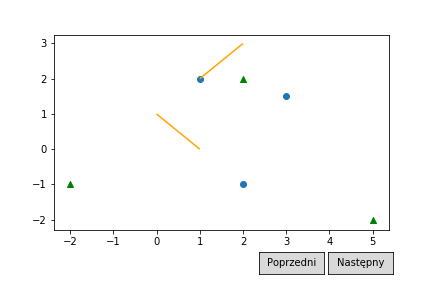

In [59]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], 'green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]], 'orange')]), 
        Scene([PointsCollection([(1, 2), (-15, 1.5), (2, -1)], 'red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], 'black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.draw() 


### Rozwiązanie

Poniższy kod definiuje funkcje do tworzenia zbiorów w punkcie 3 (i tym samym w punkcie 1).

In [56]:
from random import choice
from random import random

import math

class Vector:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def len(self):
        return math.sqrt(math.pow(self.x, 2) + math.pow(self.y, 2))

    def __eq__(self, other):
        return self.x == other.x and self.y == other.y

    def to_unit_vector(self):
        length = self.len()
        
        return Vector(self.x / length, self.y / length)
    
    def to_point(self):
        return self.x, self.y
    
    def subtract(self, other):
        return Vector(self.x - other.x, self.y - other.y)
        
    def add(self, other):
        return Vector(self.x + other.x, self.y + other.y)
        
    def scale(self, to_length):
        a = to_length / self.len()
        
        return Vector(a * self.x, a * self.y)

def generate_point_on_line(a: Vector, b: Vector):
    vector = b.subtract(a)
    scale = random() * vector.len()
    dv = vector.scale(scale)
    point = a.add(dv)
    
    return point.to_point()

def random_set_a(n, lower, upper):
    maximum = abs(upper - lower)
    points = []
    
    for i in range(n):
        x = random() * maximum + lower
        y = random() * maximum + lower
        point = (x, y)
        
        points.append(point)
        
    return points

def random_set_b(n, center: Vector, radius):
    points = []
    
    for i in range(n):
        a = random() * 2 * math.pi
        x = radius * math.cos(a) + center.x
        y = radius * math.sin(a) + center.y
        
        point = (x, y)
        points.append(point)
        
    return points

def random_set_c(n, a: Vector, b: Vector, c: Vector, d: Vector):
    points = []
    possibilities = [a, b, c, d]
    
    start = choice(possibilities)
    end = start
    
    while start == end:
        end = choice(possibilities)
        
    for i in range(n):
        point = generate_point_on_line(start, end)
        points.append(point)
    
    return points

def random_set_d(n_diagonal, n_sides, lower_left: Vector = Vector(0.0, 0.0), upper_right: Vector = Vector(10.0, 10.0)):
    upper_left = Vector(lower_left.x, upper_right.y)
    lower_right = Vector(upper_right.x, lower_left.y)
    
    points = [
        lower_left.to_point(), lower_right.to_point(),
              upper_left.to_point(), upper_right.to_point()]
    
    return points

## Graficzna wizualizacja utworzonych zbiorów

<IPython.core.display.Javascript object>


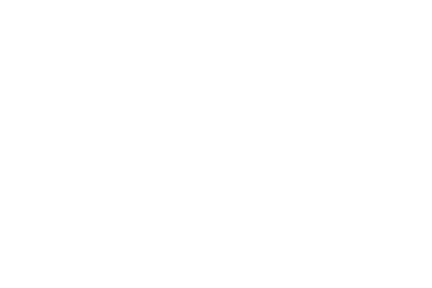

In [57]:
%matplotlib notebook

points_a = random_set_a(100, -100, 100)
points_b = random_set_b(100, Vector(0, 0), 10)
points_c = random_set_c(100, Vector(-10, 10), Vector(-10, -10), Vector(10, -10), Vector(10, 10))

plot = Plot([
    Scene([PointsCollection(points_a)]),
    Scene(PointsCollection(points_b)),
    Scene(PointsCollection(points_c)) ])

plot.draw()

## Implementacja algorytmów szukających otoczki wypukłej:
   - Algorytm Jarvisa
   - Algorytm Grahama


<IPython.core.display.Javascript object>


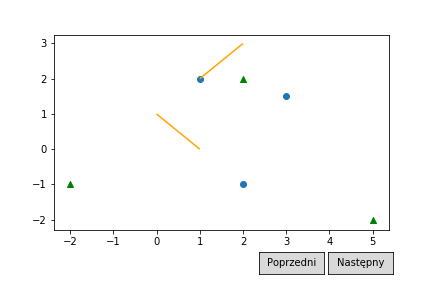

In [58]:
%matplotlib notebook

def jarvis(points):
    pass

def graham(points):
    pass

plot = Plot([Scene([PointsCollection((0.5, 0.5))])])
plot.draw()
